# Solutions


In [ ]:
# Standard Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit‑learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Plotting defaults
%matplotlib inline
sns.set(style="whitegrid", context="talk")

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [ ]:
# Paths to data files (adjust if necessary)
SENSORS_PATH = 'wearable_sensors.csv'
# Load the data
sensors_df = pd.read_csv(SENSORS_PATH)

print("Sensors shape:", sensors_df.shape)

Sensors shape: (400, 10)


## Exercise 1 – Multivariate Analysis of Wearable Sensor Data

In [ ]:
# Standardise the sensor variables
X_sensors = sensors_df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sensors)

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Scree & cumulative variance plots
exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(range(1, len(exp_var)+1), exp_var, alpha=0.7, label='Individual')
ax1.plot(range(1, len(cum_var)+1), cum_var, marker='o', label='Cumulative')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree & Cumulative Variance Curves')
ax1.axhline(0.95, linestyle='--', color='grey')
ax1.legend()
plt.tight_layout()
# plt.savefig('scree_curve.png', dpi=150)
plt.show()

NameError: name 'sensors_df' is not defined

In [ ]:
# How many PCs explain >=80 % of variance?
n_components_95 = np.argmax(cum_var >= 0.95) + 1
print(f"Number of components to reach 95 % explained variance: {n_components_95}")

Number of components to reach 95 % explained variance: 5


In [ ]:
pca2 = PCA(n_components=2)
pca2.fit(X_scaled)
pca2.components_

array([[-0.00199735,  0.23996974, -0.10411   , -0.46679666,  0.22444289,
         0.50127143,  0.41657254, -0.46161586, -0.14727944, -0.0609242 ],
       [ 0.10594106, -0.49711346, -0.46355478, -0.05758185, -0.11209189,
         0.2086282 ,  0.07935878, -0.03358033,  0.32050689,  0.59767512]])

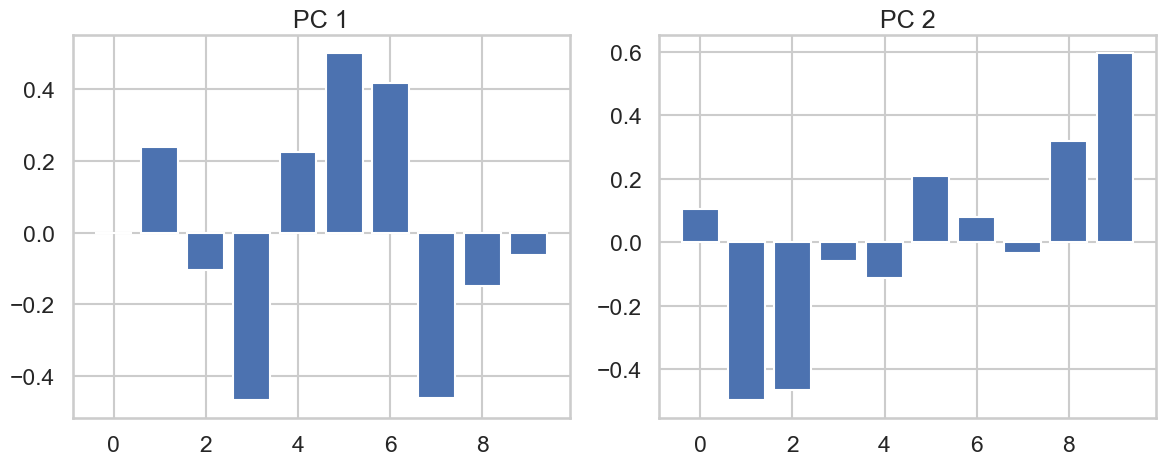

In [ ]:
loadings = pca.components_.T
K = len(loadings[:,0])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i in range(2):
    ax[i].bar(np.arange(K), loadings[:,i])
    # ax[i].set_xticks(np.arange(0 , K))
    # ax[i].set_xticklabels(np.arange(1 , K+1))
    ax[i].set_title("PC {0}".format(i+1))

plt.tight_layout()
# plt.savefig('pc_loadings.png', dpi=150)
plt.show()


In [ ]:
print(KMeans.__doc__)

K-Means clustering.

    Read more in the :ref:`User Guide <k_means>`.

    Parameters
    ----------

    n_clusters : int, default=8
        The number of clusters to form as well as the number of
        centroids to generate.

        For an example of how to choose an optimal value for `n_clusters` refer to
        :ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.

    init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
        Method for initialization:

        * 'k-means++' : selects initial cluster centroids using sampling             based on an empirical probability distribution of the points'             contribution to the overall inertia. This technique speeds up             convergence. The algorithm implemented is "greedy k-means++". It             differs from the vanilla k-means++ by making several trials at             each sampling step and choosing the best centroid among 

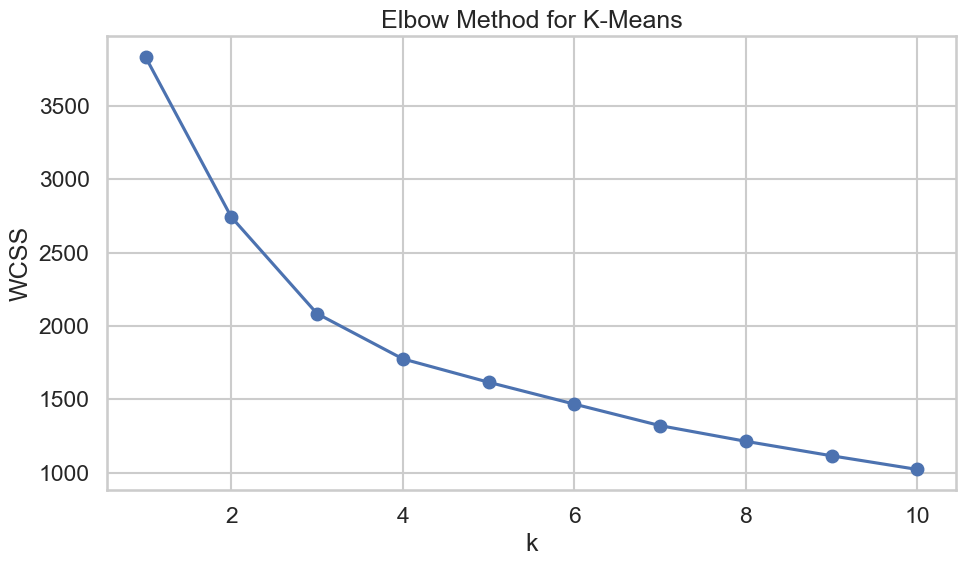

In [ ]:
# Retain PCs explaining >=95 % variance
X_reduced = X_pca[:, :n_components_95]

# ---------------- K‑Means: Elbow method ----------------
wcss = []
K_RANGE = range(1, 11)
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_reduced)
    wcss.append(km.inertia_)

plt.figure(figsize=(10,6))
plt.plot(K_RANGE, wcss, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Elbow Method for K-Means')
plt.tight_layout()
# plt.savefig('elbow_kmeans.png', dpi=150)
plt.show()

In [ ]:
# Fit final K‑Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
kmeans.fit(X_reduced)
kmeans_labels = kmeans.labels_
kmeans_sil = silhouette_score(X_reduced, kmeans_labels)
print(f"K‑Means silhouette score: {kmeans_sil:.3f}")
print(f"Optimal WCSS: {kmeans.inertia_:.2f}")

K‑Means silhouette score: 0.307
Optimal WCSS: 2083.67


In [ ]:
# ---------------- Hierarchical clustering ----------------

hier = AgglomerativeClustering(n_clusters=3, linkage='average')
hier_labels = hier.fit_predict(X_reduced)
hier_sil = silhouette_score(X_reduced, hier_labels)
print(f"Hierarchical (average) silhouette score: {hier_sil:.3f}")

# Compare which algorithm is better
better = 'K‑Means' if kmeans_sil > hier_sil else 'Hierarchical'
print(f"Better clustering based on silhouette: {better}")

Hierarchical (average) silhouette score: 0.256
Better clustering based on silhouette: K‑Means


In [ ]:
# ---------------- Gaussian Mixture Models ----------------
bics, gmms = [], []
for m in range(1, 6):
    gmm = GaussianMixture(n_components=m, covariance_type='full', random_state=42, n_init=10)
    gmm.fit(X_reduced)
    bics.append(gmm.bic(X_reduced))
    gmms.append(gmm)

best_idx = np.argmin(bics)
best_gmm = gmms[best_idx]
gmm_labels = best_gmm.predict(X_reduced)
print(f"Best GMM components by BIC: {best_idx+1}")

Best GMM components by BIC: 3


Adjusted Rand Index (GMM vs K‑Means): 0.823


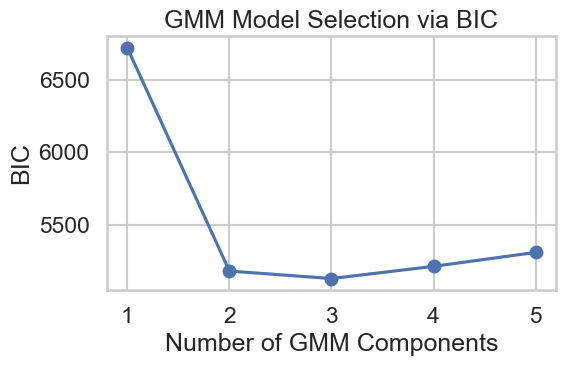

In [ ]:
ari_gmm_kmeans = adjusted_rand_score(kmeans_labels, gmm_labels)
print(f"Adjusted Rand Index (GMM vs K‑Means): {ari_gmm_kmeans:.3f}")

# Plot BIC curve
plt.figure(figsize=(6,4))
plt.plot(range(1,6), bics, marker='o')
plt.xlabel('Number of GMM Components')
plt.ylabel('BIC')
plt.title('GMM Model Selection via BIC')
plt.tight_layout()
plt.savefig('gmm_bic.png', dpi=150)
plt.show()

## Exercise 2 – Credit Default Classification

In [ ]:
CREDIT_PATH = "credit_default.csv"
credit_df  = pd.read_csv(CREDIT_PATH)

# Separate predictors and response
X = credit_df.drop(columns=['default'])
y = credit_df['default']

# Train‑test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Feature scaling
scaler_cd = StandardScaler()
X_train_scaled = scaler_cd.fit_transform(X_train)
X_test_scaled  = scaler_cd.transform(X_test)

In [ ]:
# Standard (unpenalised) logistic regression using very large C
base_logreg = LogisticRegression(
    penalty='l2', C=1e6, solver='liblinear', max_iter=1000
)

cv_acc = cross_val_score(
    base_logreg, X_train_scaled, y_train, cv=10, scoring='accuracy').mean()

base_logreg.fit(X_train_scaled, y_train)
test_acc = base_logreg.score(X_test_scaled, y_test)

print(f"Standard logistic – CV accuracy:  {cv_acc:.3f}")
print(f"Standard logistic – Test accuracy: {test_acc:.3f}")

Standard logistic – CV accuracy:  0.743
Standard logistic – Test accuracy: 0.650


In [ ]:
Cs = np.logspace(-3, 3, 15)
# Ridge (L2)
ridge_search = GridSearchCV(
    LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000),
    param_grid={'C': Cs}, cv=10, scoring='accuracy'
)
ridge_search.fit(X_train_scaled, y_train)
ridge_best = ridge_search.best_estimator_
ridge_cv_acc = ridge_search.best_score_
ridge_test_acc = ridge_best.score(X_test_scaled, y_test)

# Lasso (L1)
lasso_search = GridSearchCV(
    LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
    param_grid={'C': Cs}, cv=10, scoring='accuracy'
)
lasso_search.fit(X_train_scaled, y_train)
lasso_best = lasso_search.best_estimator_
lasso_cv_acc = lasso_search.best_score_
lasso_test_acc = lasso_best.score(X_test_scaled, y_test)

print("Ridge – best C: {:.4f}, CV acc: {:.3f}, Test acc: {:.3f}".format(
    ridge_search.best_params_['C'], ridge_cv_acc, ridge_test_acc))
print("Lasso – best C: {:.4f}, CV acc: {:.3f}, Test acc: {:.3f}".format(
    lasso_search.best_params_['C'], lasso_cv_acc, lasso_test_acc))

Ridge – best C: 0.0072, CV acc: 0.807, Test acc: 0.700
Lasso – best C: 0.1389, CV acc: 0.836, Test acc: 0.800


Random Forest – OOB accuracy:  0.836
Random Forest – Test accuracy: 0.767


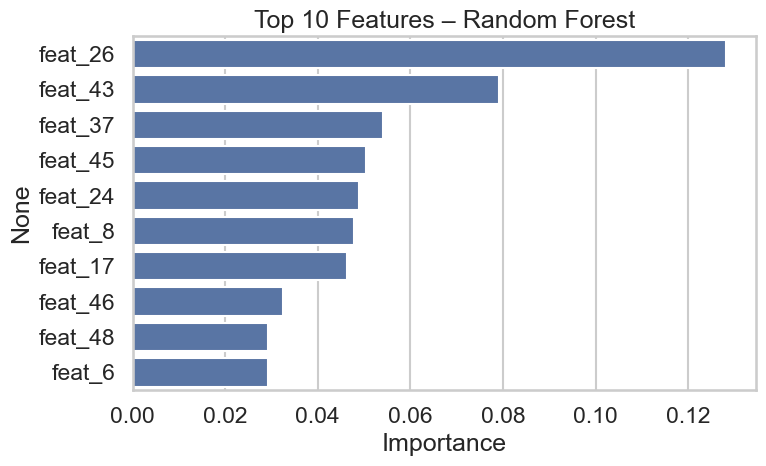

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300, oob_score=True, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)
oob_acc = rf.oob_score_
test_acc_rf = rf.score(X_test, y_test)

print(f"Random Forest – OOB accuracy:  {oob_acc:.3f}")
print(f"Random Forest – Test accuracy: {test_acc_rf:.3f}")

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
top10_rf = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top10_rf.values, y=top10_rf.index)
plt.xlabel("Importance")
plt.title("Top 10 Features – Random Forest")
plt.tight_layout()
plt.savefig('rf_top10.png', dpi=150)
plt.show()

In [ ]:
lasso_best.coef_[0]

array([-0.1007288 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.0178321 , -0.04601225,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.4736064 ,  0.        ,
        0.89263512,  0.        ,  0.        ,  0.        ,  0.13983405,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.06474376,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.76064438,  0.        ,  0.        ,
        0.        ,  0.13250964,  0.        ,  0.        ,  0.        ])

In [ ]:
# Features selected by Lasso (non‑zero coefficients)
coef_series = pd.Series(lasso_best.coef_[0], index=X.columns)
lasso_selected = coef_series[coef_series.abs() > 1e-12].index.tolist()

# Align feature universe
union_feats = sorted(set(top10_rf.index).union(lasso_selected))
rf_labels    = [1 if feat in top10_rf.index else 0 for feat in union_feats]
lasso_labels = [1 if feat in lasso_selected else 0 for feat in union_feats]

ari_feats = adjusted_rand_score(rf_labels, lasso_labels)
print(f"Adjusted Rand Index between RF top‑10 and Lasso‑selected features: {ari_feats:.3f}")

NameError: name 'pd' is not defined

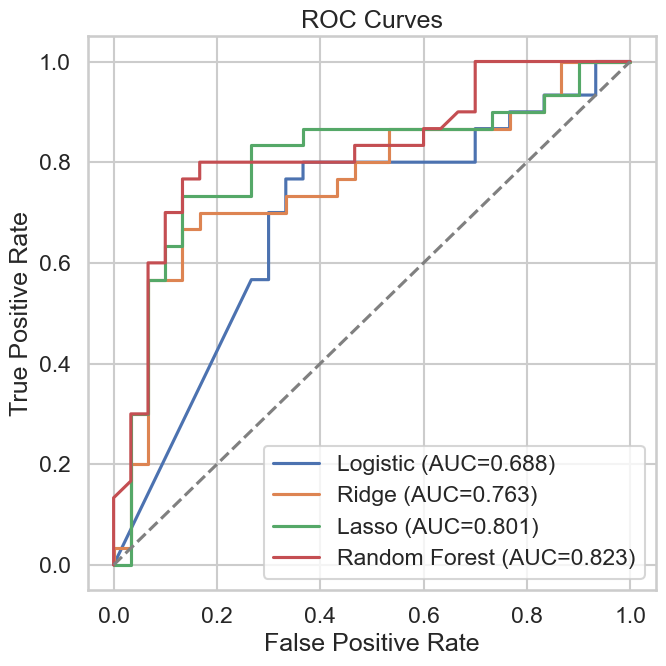

In [ ]:
# Probabilities for ROC
base_probs   = base_logreg.predict_proba(X_test_scaled)[:,1]
ridge_probs  = ridge_best.predict_proba(X_test_scaled)[:,1]
lasso_probs  = lasso_best.predict_proba(X_test_scaled)[:,1]
rf_probs     = rf.predict_proba(X_test)[:,1]

# Compute ROC + AUC
models = {
    'Logistic': base_probs,
    'Ridge':    ridge_probs,
    'Lasso':    lasso_probs,
    'Random Forest': rf_probs
}
plt.figure(figsize=(7,7))
for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150)
plt.show()
